In [1]:
import numpy as np
import pandas as pd
import nltk
import json
import yaml
import string
from yaml import load, dump
try:
    from yaml import CLoader as Loader, CDumper as Dumper
except ImportError:
    from yaml import Loader, Dumper

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM , Dense, GlobalMaxPooling1D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [137]:
%%writefile nlu.yaml
---
version: "3.1"
nlu:
- intent: greet
  examples: |
    - hey
    - hello
    - hi
    - hello there
    - good morning
    - good evening
    - moin
    - hey there
    - let's go
    - hey dude
    - goodmorning
    - goodevening
    - good afternoon
    - hiya
    - howdy
    - greetings
    - hi there
    - hey you
    - hi friend
- intent: goodbye
  examples: |
    - cu
    - good by
    - cee you later
    - good night
    - bye
    - goodbye
    - have a nice day
    - see you around
    - bye bye
    - see you later
    - farewell
    - adios
    - take care
    - catch you later
    - so long
    - until next time
    - see ya
    - bye for now
- intent: affirm
  examples: |
    - yes
    - y
    - indeed
    - of course
    - that sounds good
    - correct
    - absolutely
    - definitely
    - sure thing
    - you bet
- intent: deny
  examples: |
    - no
    - n
    - never
    - I don't think so
    - don't like that
    - no way
    - not really
    - nah
    - I disagree
    - I'm not sure
- intent: mood_great
  examples: |
    - perfect
    - great
    - amazing
    - feeling like a king
    - wonderful
    - I am feeling very good
    - I am great
    - I am amazing
    - I am going to save the world
    - super stoked
    - extremely good
    - so so perfect
    - so good
    - so perfect
    - fantastic
    - outstanding
    - top-notch
    - on cloud nine
- intent: mood_unhappy
  examples: |
    - my day was horrible
    - I am sad
    - I don't feel very well
    - I am disappointed
    - super sad
    - I'm so sad
    - sad
    - very sad
    - unhappy
    - not good
    - not very good
    - extremly sad
    - so saad
    - so sad
    - terrible
    - awful
    - dreadful
    - miserable
    - depressed
    - down in the dumps
- intent: bot_challenge
  examples: |
    - are you a bot?
    - are you a human?
    - am I talking to a bot?
    - am I talking to a human?
    - prove you're a bot
    - are you real?
    - human or machine?
    - can you pass the Turing test?
    - I can't tell
    - how are you
- intent: request_weather
  examples: |
    - What's the weather like today?
    - Can you tell me the weather forecast?
    - Is it going to rain tomorrow?
    - I need weather information.
    - Tell me about the weather.
    - What's the temperature right now?
    - Is it sunny outside?
    - Weather update, please.
    - I want to know the weather conditions.
    - Give me a weather report.
    - What's the weather in New York?
    - Tell me if I need an umbrella today.
    - Any weather alerts?
    - Check the weather for my location.
    - I'm planning an outdoor activity, how's the weather?
- intent: order_food
  examples: |
    - I'd like to order a pizza.
    - Can I get a cheeseburger, please?
    - I'm hungry, let's order food.
    - What's on the menu?
    - How can I order some sushi?
    - I want a vegetarian meal.
    - Do you deliver food?
    - I'll have a large pepperoni pizza.
    - I need food delivery.
    - Can you recommend a good restaurant?
    - I'm in the mood for Chinese food.
    - What's your special today?
    - Order me a salad, please.
    - Add some fries to my order.
    - I'd like to place an order for delivery.
- intent: inquire_about_services
  examples: |
    - What services do you offer?
    - Tell me more about your products.
    - Can you explain your services?
    - What are your service hours?
    - Do you have any discounts?
    - How does your service work?
    - Can I get a free trial?
    - What's your pricing?
    - Are there any additional fees?
    - Do you offer customer support?
    - Tell me about your subscription options.
    - What's included in your package?
    - How can I get started with your service?
    - Explain your features, please.
    - What sets you apart from competitors?
- intent: request_recommendation
  examples: |
    - Recommend a good book to read.
    - Suggest a movie for tonight.
    - What music should I listen to?
    - Can you suggest a vacation destination?
    - I need a restaurant recommendation.
    - Recommend a workout routine.
    - What's a great TV series to watch?
    - Suggest a new hobby for me.
    - Recommend a gift for my friend.
    - Tell me about some must-visit places.
    - Suggest a recipe for dinner.
    - Recommend a fitness app.
    - What should I do for fun?
    - Suggest a podcast to listen to.
    - Recommend a game to play.
- intent: inquire_about_location
  examples: |
    - Where are you located?
    - What's your address?
    - Can you give me directions?
    - Are you close to downtown?
    - Tell me your office hours.
    - Do you have multiple locations?
    - Where can I find you?
    - Is there parking available?
    - Are you in the city center?
    - What's the nearest landmark?
    - How far are you from the airport?
    - Can I visit your store today?
    - Give me your GPS coordinates.
    - Tell me your store hours.
    - Where should I meet you?
- intent: request_contact_info
  examples: |
    - Can I have your phone number?
    - What's your email address?
    - How can I contact you?
    - Give me your customer support number.
    - What's the best way to reach you?
    - Provide your contact information.
    - Do you have a contact form?
    - Can I chat with you online?
    - I need your contact details.
    - What's your support email?
    - Tell me your social media profiles.
    - Can I call your office?
    - How do I get in touch with you?
    - Share your contact info, please.
    - I want to email you.
- intent: greet
  examples: |
    - hey there
    - good afternoon
    - hiya
    - howdy
    - greetings
    - hi there
    - hey you
    - hi friend
    - hey folks
    - hello everyone
    - hey buddy
    - hi folks
    - hey team
    - hi folks
    - hey you all
    - hi mate
    - hello team
    - hey friend
    - hi dear
    - hey guys

- intent: goodbye
  examples: |
    - see you soon
    - farewell, my friend
    - take it easy
    - until we meet again
    - goodbye for now
    - have a great day
    - see you next time
    - catch you on the flip side
    - bye for now, buddy
    - adieu
    - bye-bye, friend
    - see you in a while
    - peace out
    - bye, take care
    - have a wonderful evening
    - see you in a bit
    - farewell, mate
    - goodbye, friend
    - until later, alligator
    - see you shortly

- intent: affirm
  examples: |
    - absolutely sure
    - you're right
    - indeed, that's correct
    - affirmative
    - yeah, I agree
    - for sure
    - that's a fact
    - you got it
    - no doubt about it
    - I concur
    - that's accurate
    - it's true
    - positively
    - without a doubt
    - correct as always
    - I'm in agreement
    - I couldn't agree more
    - that's the way
    - that's right on
    - I'm with you on that

- intent: deny
  examples: |
    - absolutely not
    - I disagree completely
    - never in a million years
    - no chance
    - not at all
    - not in my wildest dreams
    - I'm not buying it
    - nope, not a chance
    - I'm not so sure
    - I can't agree with that
    - I beg to differ
    - not really my thing
    - I'm not feeling it
    - not in my book
    - I'm not convinced
    - not happening
    - not on your life
    - I'm skeptical
    - I'm not on board
    - I have my doubts

- intent: mood_great
  examples: |
    - over the moon
    - feeling fantastic
    - on top of the world
    - I'm ecstatic
    - couldn't be better
    - life's a dream
    - feeling euphoric
    - living the dream
    - pure bliss
    - everything's going my way
    - I'm in seventh heaven
    - absolutely elated
    - having a fantastic day
    - it's a perfect day
    - feeling like a superstar
    - loving life right now
    - absolutely thrilled
    - I'm on cloud nine
    - feeling incredible
    - today is amazing

- intent: mood_unhappy
  examples: |
    - I'm really down
    - feeling awful
    - it's a terrible day
    - I'm so disappointed
    - not a good day at all
    - feeling gloomy
    - really sad
    - deeply unhappy
    - today is dreadful
    - I'm in a bad mood
    - I'm miserable
    - nothing's going right
    - feeling blue
    - it's a lousy day
    - I'm not happy at all
    - so discouraged
    - I'm down in the dumps
    - I'm heartbroken
    - it's a tough day
    - everything is going wrong

- intent: bot_challenge
  examples: |
    - are you a real person?
    - prove you're not a human
    - can you pass the Turing test?
    - human or machine, which are you?
    - are you a chatbot?
    - are you AI?
    - what's your true identity?
    - are you a computer program?
    - are you a living being?
    - can you convince me you're not a bot?
    - are you a robot?
    - show me you're not human
    - can you fool me into thinking you're human?
    - are you made of flesh and blood?
    - can you demonstrate your humanity?
    - are you a machine or a person?
    - can you pass for a human?
    - are you sentient?
    - prove you're not an AI
    - are you a living entity?

- intent: request_weather
  examples: |
    - Tell me the weather for the weekend.
    - What's the weather like in the evening?
    - Is it sunny or cloudy today?
    - Give me a weather update for tomorrow.
    - What's the temperature in Celsius?
    - Can you check the forecast for next week?
    - Will it rain in the afternoon?
    - Do I need an umbrella?
    - What's the humidity level?
    - Tell me about the weather conditions.
    - Is it windy outside?
    - Any weather warnings?
    - What's the UV index?
    - What's the weather in my location?
    - I need the weather for my trip.
    - What's the weather in my city?
    - Is it going to snow tonight?
    - What's the weather trend?
    - Should I expect a heatwave?
    - What's the forecast for the evening?

- intent: order_food
  examples: |
    - I'd like to order a vegetarian meal.
    - Can I get some fast food, please?
    - I'm craving Italian cuisine.
    - What's your recommendation for a burger?
    - Do you offer gluten-free options?
    - I want a spicy dish.
    - How long does food delivery take?
    - What's your delivery radius?
    - I'll take a large fries.
    - Can I customize my order?
    - What's your most popular dish?
    - Do you have a kids' menu?
    - I'm a vegan; what can I order?
    - Can I see the dessert menu?
    - I need a quick snack.
    - What beverages do you have?
    - Do you have any meal deals?
    - What's the minimum order amount?
    - I want a healthy option.
    - Can I place an order online?

- intent: inquire_about_services
  examples: |
    - Tell me about your customer support.
    - Do you provide a money-back guarantee?
    - What's your cancellation policy?
    - Are there any hidden fees?
    - Can I upgrade my plan later?
    - How can I get a refund?
    - What payment methods do you accept?
    - Is there a free trial period?
    - What's included in the basic package?
    - Can I add extra features?
    - Tell me about your warranty.
    - Do you offer training sessions?
    - Is there a mobile app available?
    - Can I transfer my subscription?
    - What's the return policy?
    - Are there any special offers?
    - How do I contact your support team?
    - Can I change my plan anytime?
    - What's the setup process like?
    - Is there a user forum?

- intent: request_recommendation
  examples: |
    - Recommend a classic novel.
    - Suggest a documentary to watch.
    - I'm in the mood for jazz music.
    - What's a good historical movie?
    - Tell me about a new hobby to explore.
    - Recommend a romantic comedy.
    - Suggest a beach destination for vacation.
    - I need a restaurant for a special occasion.
    - What's the best strategy game?
    - Recommend a gift for a book lover.
    - Suggest a DIY project for the weekend.
    - What's a popular true crime podcast?
    - Recommend a local attraction.
    - I'm looking for a recipe with chicken.
    - Suggest a puzzle game for kids.
    - Tell me about a self-help book.
    - Recommend a fitness routine for beginners.
    - I want to try a new cuisine.
    - Suggest a motivational speaker.
    - What's a good fashion magazine?

- intent: inquire_about_location
  examples: |
    - Are you situated downtown?
    - What landmarks are nearby?
    - Can you provide a map?
    - Is there parking available on-site?
    - Are you in a commercial district?
    - Is your location wheelchair accessible?
    - Do you have a view of the river?
    - Are you close to public transportation?
    - Can I reach you by subway?
    - Is there a coffee shop nearby?
    - What's the closest shopping mall?
    - Are you located in a historic area?
    - Can I walk to your place?
    - Is there a gym in the vicinity?
    - Are you in a quiet neighborhood?
    - Do you have a rooftop terrace?
    - Are you near a famous park?
    - Can I find a pharmacy nearby?
    - Is there a hospital close by?
    - Are you in a residential area?

- intent: request_contact_info
  examples: |
    - How can I reach your sales team?
    - Can I contact your technical support?
    - Give me your office phone number.
    - What's the best way to email you?
    - Can I chat with your live support?
    - Provide your customer service hotline.
    - How do I get in touch with billing?
    - Do you have a 24/7 helpline?
    - Share your contact form link.
    - I need your marketing department's email.
    - What's your social media contact?
    - Can I call your headquarters?
    - How can I connect with your HR?
    - Give me your main contact email.
    - Can I reach your CEO directly?
    - What's your fax number?
    - Share your technical support chat.
    - How can I contact your PR team?
    - Can I schedule a call with management?
    - What's your after-hours contact?
- intent: inquire_about_healthcare
  examples: |
    - Tell me about Dutch healthcare
    - How does the Dutch health insurance work?
    - Explain the Long-Term Care Act in the Netherlands
    - What are the main health insurance companies in the Netherlands?
    - Do expats need Dutch health insurance?
    - What are the obligations for EU, EEA, and Swiss nationals regarding health insurance?
    - Compare Dutch health insurance packages
    - How does the Dutch healthcare system function?
    - What are the healthcare options for foreign students in the Netherlands?
    - What happens if I don't take out health insurance in the Netherlands?
    - How to apply for an assessment of Wlz insurance position?
    - What types of Dutch health insurance are there?
    - Tell me about the compulsory basic insurance in the Netherlands
    - What is covered by the basic health insurance package?
    - Explain eigen risico in Dutch health insurance
    - What is optional additional insurance in the Netherlands?
    - What additional medical treatments are covered by extra insurance?
    - How to register with a GP in the Netherlands?
    - How are children covered by Dutch health insurance?
    - What hints and tips should I know about Dutch health insurance?
    - Are doctors in the Netherlands expected to speak English?


Overwriting nlu.yaml


In [154]:
%%writefile nlu_test.yaml
version: "3.1"
nlu:
- intent: greet
  examples: |
    - hey
    - hi
    - hello
    - good morning
    - afternoon
    - evening
    - greetings
    - hey there
    - howdy

- intent: goodbye
  examples: |
    - bye
    - see you later
    - farewell
    - take care
    - until next time
    - goodbye for now
    - see you soon
    - have a great day

- intent: affirm
  examples: |
    - yes
    - absolutely
    - sure
    - indeed
    - definitely
    - of course
    - absolutely right
    - I agree
    - that's correct

- intent: deny
  examples: |
    - no
    - never
    - I disagree
    - not really
    - I'm not so sure
    - I don't think so
    - I beg to differ
    - absolutely not

- intent: mood_great
  examples: |
    - feeling awesome
    - ecstatic
    - on cloud nine
    - fantastic
    - incredible
    - marvelous
    - amazing day
    - I'm so happy

- intent: mood_unhappy
  examples: |
    - feeling sad
    - not so good
    - disappointed
    - miserable
    - upset
    - downhearted
    - having a rough day
    - things aren't going well

- intent: bot_challenge
  examples: |
    - are you a real person?
    - prove you're not a bot
    - human or machine?
    - tell me a joke
    - can you solve this captcha?
    - are you sentient?

- intent: request_weather
  examples: |
    - What's the weather today?
    - Tell me about the forecast.
    - Is it going to rain?
    - Give me the weather update.
    - Will I need an umbrella?
    - How's the weather looking tomorrow?
    - Any chance of snow?

- intent: order_food
  examples: |
    - I want to order pizza.
    - Can I get a burger, please?
    - What's on the menu?
    - I'm hungry, recommend something.
    - Could you suggest a vegetarian dish?
    - Any specials or promotions on food?

- intent: inquire_about_services
  examples: |
    - Tell me about your services.
    - Do you offer any discounts?
    - How does your service work?
    - Any special promotions?
    - Can you explain your subscription plans?
    - What are the available features?

- intent: request_recommendation
  examples: |
    - Recommend a good movie.
    - Suggest a book to read.
    - Any music recommendations?
    - What's a popular TV show right now?
    - Any must-read novels?
    - Can you suggest a classic film?

- intent: inquire_about_location
  examples: |
    - Where are you located?
    - What's your address?
    - Can you give me directions?
    - How far are you from downtown?
    - Is your store centrally located?
    - What's the nearest landmark?

- intent: request_contact_info
  examples: |
    - Can I have your phone number?
    - What's your email address?
    - How can I contact you?
    - Share your contact details.
    - Can you provide a contact number?
    - What's the best way to reach you? 

- intent: inquire_about_healthcare
  examples: |
    - Can you recommend a good Dutch health insurance company?
    - What is the average monthly premium for Dutch health insurance?
    - How do I register for Dutch health insurance as an expat from the EU?
    - Explain the coverage of basic health insurance in the Netherlands.
    - What are the exceptions to the rule for Wlz insurance in the Netherlands?
    - How does the Dutch government fund the healthcare system?
    - Tell me about the costs associated with Dutch health insurance.
    - Is there a waiting period for certain healthcare services in the Netherlands?
    - Can you provide information on healthcare options for international students?
    - What's the penalty if I don't take out health insurance within four months in the Netherlands?
    - How do I apply for an assessment of my Wlz insurance position?
    - Are there limitations on changing health insurance providers in the Netherlands?
    - What are the benefits of having a collective agreement with an insurance company in the Netherlands?
    - Explain the coverage for dental care in the basic health insurance package.
    - Can I choose a different health insurance provider for my child under 18?
    - How does the healthcare allowance work for those on a low income in the Netherlands?
    - What are the language expectations for doctors in the Netherlands?


Overwriting nlu_test.yaml


In [155]:
with open('nlu.yaml') as content:
    data = yaml.load(content,Loader=Loader)
with open('responses.yaml') as content:
    data_response = yaml.load(content, Loader = Loader)
with open('nlu_test.yaml') as content:
    data_test = yaml.load(content,Loader=Loader)

In [156]:
# Create an empty list to store the data
parsed_data = []

# Iterate through the 'nlu' section of the YAML data
for item in data['nlu']:
    intent = item['intent']
    examples = item['examples']
    
    # Split the examples by line and remove leading/trailing whitespace
    examples_list = [line.strip() for line in examples.split('\n') if line.strip()]
    
    # Append each example-intent pair to the parsed_data list
    for example in examples_list:
        parsed_data.append({'example': example, 'intent': intent})

# Create a DataFrame from the parsed data
df = pd.DataFrame(parsed_data)
        

In [157]:
# Create an empty list to store the data
parsed_data_test = []

# Iterate through the 'nlu' section of the YAML data
for item in data_test['nlu']:
    intent = item['intent']
    examples = item['examples']
    
    # Split the examples by line and remove leading/trailing whitespace
    examples_list = [line.strip() for line in examples.split('\n') if line.strip()]
    
    # Append each example-intent pair to the parsed_data list
    for example in examples_list:
        parsed_data_test.append({'example': example, 'intent': intent})

# Create a DataFrame from the parsed data
df_test = pd.DataFrame(parsed_data_test)
    

In [158]:
df

example  \
0                                                - hey   
1                                              - hello   
2                                                 - hi   
3                                        - hello there   
4                                       - good morning   
..                                                 ...   
471  - What additional medical treatments are cover...   
472    - How to register with a GP in the Netherlands?   
473  - How are children covered by Dutch health ins...   
474  - What hints and tips should I know about Dutc...   
475  - Are doctors in the Netherlands expected to s...   

                       intent  
0                       greet  
1                       greet  
2                       greet  
3                       greet  
4                       greet  
..                        ...  
471  inquire_about_healthcare  
472  inquire_about_healthcare  
473  inquire_about_healthcare  
474  inquire_about_healthcare  
475  inquire_about_healthcare  

[476 rows x 2 columns]

In [159]:
df_test

example  \
0                                                - hey   
1                                                 - hi   
2                                              - hello   
3                                       - good morning   
4                                          - afternoon   
..                                                 ...   
105  - What are the benefits of having a collective...   
106  - Explain the coverage for dental care in the ...   
107  - Can I choose a different health insurance pr...   
108  - How does the healthcare allowance work for t...   
109  - What are the language expectations for docto...   

                       intent  
0                       greet  
1                       greet  
2                       greet  
3                       greet  
4                       greet  
..                        ...  
105  inquire_about_healthcare  
106  inquire_about_healthcare  
107  inquire_about_healthcare  
108  inquire_about_healthcare  
109  inquire_about_healthcare  

[110 rows x 2 columns]

In [189]:
intent_counts = df.groupby('intent').size().reset_index(name='count')
intent_counts_test = df_test.groupby('intent').size().reset_index(name='count')
# Add a random example from each category
random_examples = df.groupby('intent').apply(lambda group: group.sample(1)).reset_index(drop=True)
random_examples_test = df_test.groupby('intent').apply(lambda group: group.sample(1)).reset_index(drop=True)
# Merge the intent_counts and random_examples DataFrames
intent_counts = pd.merge(intent_counts, random_examples, on='intent')
intent_counts_test = pd.merge(intent_counts_test, random_examples_test, on='intent')

In [190]:
intent_counts

intent  count  \
0                     affirm     30   
1              bot_challenge     30   
2                       deny     30   
3                    goodbye     38   
4                      greet     39   
5   inquire_about_healthcare     21   
6     inquire_about_location     35   
7     inquire_about_services     35   
8                 mood_great     38   
9               mood_unhappy     40   
10                order_food     35   
11      request_contact_info     35   
12    request_recommendation     35   
13           request_weather     35   

                                              example  
0                                              indeed  
1                          are you a computer program  
2                                                  no  
3                            have a wonderful evening  
4                                                 hey  
5    what is covered by the basic health insurance...  
6                           are you situated downtown  
7                         can i upgrade my plan later  
8                                 absolutely thrilled  
9                                              so sad  
10                            order me a salad please  
11                    whats your social media contact  
12                 i need a restaurant recommendation  
13                                 whats the uv index

In [179]:
intent_counts_test

intent  count  \
0                     affirm      9   
1              bot_challenge      6   
2                       deny      8   
3                    goodbye      8   
4                      greet      9   
5   inquire_about_healthcare     17   
6     inquire_about_location      6   
7     inquire_about_services      6   
8                 mood_great      8   
9               mood_unhappy      8   
10                order_food      6   
11      request_contact_info      6   
12    request_recommendation      6   
13           request_weather      7   

                                              example  
0                                          definitely  
1                                    are you sentient  
2                                      im not so sure  
3                                           take care  
4                                             evening  
5    what are the language expectations for doctor...  
6                                  whats your address  
7                         tell me about your services  
8                                           marvelous  
9                                        disappointed  
10                              i want to order pizza  
11                       can i have your phone number  
12                     can you suggest a classic film  
13                                is it going to rain

In [163]:
df['example'] = df['example'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [164]:
df_test['example'] = df_test['example'].str.lower().str.translate(str.maketrans('', '', string.punctuation))

In [165]:
df

example  \
0                                                  hey   
1                                                hello   
2                                                   hi   
3                                          hello there   
4                                         good morning   
..                                                 ...   
471   what additional medical treatments are covere...   
472       how to register with a gp in the netherlands   
473   how are children covered by dutch health insu...   
474   what hints and tips should i know about dutch...   
475   are doctors in the netherlands expected to sp...   

                       intent  
0                       greet  
1                       greet  
2                       greet  
3                       greet  
4                       greet  
..                        ...  
471  inquire_about_healthcare  
472  inquire_about_healthcare  
473  inquire_about_healthcare  
474  inquire_about_healthcare  
475  inquire_about_healthcare  

[476 rows x 2 columns]

In [166]:
df_test

example  \
0                                                  hey   
1                                                   hi   
2                                                hello   
3                                         good morning   
4                                            afternoon   
..                                                 ...   
105   what are the benefits of having a collective ...   
106   explain the coverage for dental care in the b...   
107   can i choose a different health insurance pro...   
108   how does the healthcare allowance work for th...   
109   what are the language expectations for doctor...   

                       intent  
0                       greet  
1                       greet  
2                       greet  
3                       greet  
4                       greet  
..                        ...  
105  inquire_about_healthcare  
106  inquire_about_healthcare  
107  inquire_about_healthcare  
108  inquire_about_healthcare  
109  inquire_about_healthcare  

[110 rows x 2 columns]

In [167]:
##from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = 2000)
tokenizer.fit_on_texts(df['example'])
train = tokenizer.texts_to_sequences(df['example'])
#apply padding
from tensorflow. keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences (train)

#encoding the outputs
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(df['intent'])

In [168]:
test = tokenizer.texts_to_sequences(df_test['example'])
x_test = pad_sequences(test, maxlen = x_train.shape[1])

y_test = le.transform(df_test['intent'])

In [169]:
input_shape = x_train.shape[1]
input_shape

13

In [170]:
#define vocabulary
vocabulary = len(tokenizer.word_index)
print("number of unique words : ", vocabulary)
output_length = le.classes_.shape[0]
print("output length: ", output_length)

number of unique words :  591
output length:  14


In [171]:
i = Input (shape= (input_shape,))
x = Embedding(vocabulary+1,10) (i)
x = LSTM(10, return_sequences=True) (x)
x = Flatten() (x)
x = Dense (output_length, activation="softmax") (x)
model = Model (i, x)

In [172]:
model.compile (loss="sparse_categorical_crossentropy", optimizer='adam',metrics=['accuracy'])

In [173]:
train = model.fit (x_train,y_train, epochs=100)

Epoch 1/100


2024-01-10 15:30:35.517566: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-10 15:30:35.649783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


 1/15 [=>............................] - ETA: 13s - loss: 2.6360 - accuracy: 0.0312

2024-01-10 15:30:35.782574: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


15/15 [==============================] - 1s 31ms/step - loss: 2.6352 - accuracy: 0.0651
Epoch 2/100
15/15 [==============================] - 0s 21ms/step - loss: 2.6242 - accuracy: 0.0903
Epoch 3/100
15/15 [==============================] - 0s 17ms/step - loss: 2.6071 - accuracy: 0.0840
Epoch 4/100
15/15 [==============================] - 0s 14ms/step - loss: 2.5792 - accuracy: 0.0987
Epoch 5/100
15/15 [==============================] - 0s 15ms/step - loss: 2.5336 - accuracy: 0.1366
Epoch 6/100
15/15 [==============================] - 0s 14ms/step - loss: 2.4697 - accuracy: 0.1261
Epoch 7/100
15/15 [==============================] - 0s 12ms/step - loss: 2.3738 - accuracy: 0.1975
Epoch 8/100
15/15 [==============================] - 0s 12ms/step - loss: 2.2558 - accuracy: 0.2059
Epoch 9/100
15/15 [==============================] - 0s 14ms/step - loss: 2.1372 - accuracy: 0.1828
Epoch 10/100
15/15 [==============================] - 0s 15ms/step - loss: 2.0458 - accuracy: 0.2290
Epoch 11/10

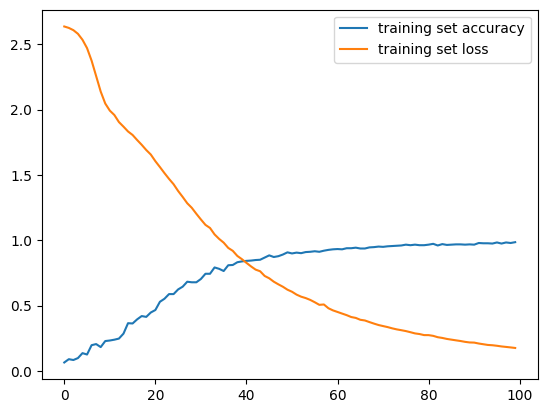

In [174]:
plt.plot (train.history['accuracy'],label='training set accuracy')
plt.plot (train.history['loss'],label='training set loss')
plt.legend ()

In [175]:
from sklearn.metrics import classification_report

# Assuming you have a trained model named 'model'
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=-1)

# Convert numeric labels back to original labels
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred_classes)

# Print classification report
print(classification_report(y_test_labels, y_pred_labels))

1/4 [======>.......................] - ETA: 0s

2024-01-10 15:30:55.257441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-01-10 15:30:55.303955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 51ms/step
                          precision    recall  f1-score   support

                  affirm       0.62      0.89      0.73         9
           bot_challenge       1.00      0.83      0.91         6
                    deny       0.80      1.00      0.89         8
                 goodbye       1.00      1.00      1.00         8
                   greet       0.64      1.00      0.78         9
inquire_about_healthcare       1.00      0.94      0.97        17
  inquire_about_location       0.86      1.00      0.92         6
  inquire_about_services       1.00      0.67      0.80         6
              mood_great       1.00      0.75      0.86         8
            mood_unhappy       0.75      0.38      0.50         8
              order_food       0.80      0.67      0.73         6
    request_contact_info       0.86      1.00      0.92         6
  request_recommendation       0.60      0.50      0.55         6
         request_weathe

In [65]:
import random

while True:
    texts_p = []
    prediction_input = input('You : ')
    #removing punctuation and converting to lowercase
    prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
    prediction_input = "".join(prediction_input)
    texts_p.append(prediction_input)
    #tokenizing and padding
    prediction_input = tokenizer.texts_to_sequences (texts_p)
    prediction_input = np.array (prediction_input).reshape(-1)
    prediction_input = pad_sequences ([prediction_input], input_shape)
    #getting output from model
    output = model.predict(prediction_input)
    print(output)
    output = output.argmax()
    #finding the right tag and predicting
    response_tag = le.inverse_transform([output])[0]
    print(response_tag)
    #print("BOT : ", random.choice (responses [response_tag]))
    #if response_tag == "goodbye":
    #    break

You :  Tell me about the forecast


1/1 [==============================] - 0s 21ms/step
[[2.6549975e-07 2.2896682e-03 9.9896670e-07 3.1481017e-04 6.8438500e-03
  1.9046098e-02 9.4822962e-03 4.3929103e-06 2.9450148e-05 8.0088098e-03
  4.4931778e-05 3.3108085e-02 9.2082620e-01]]
request_weather


KeyboardInterrupt: Interrupted by user

In [ ]:
# Automatic Testing